In [19]:
# BGS-Net (Bottleneck-Gated Segmentation Network) Inference Notebook
# Inference using BGS-Net on the LandCoverAI dataset


In [20]:
# Standard imports
import os
import time
import glob
import shutil
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

# Data handling and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
from tqdm import tqdm

# PyTorch imports
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from torchmetrics import JaccardIndex

# Image processing
import cv2
import albumentations as A 

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)


In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Dataset and directory paths - Update these to your local paths
DATASET_NAME = 'landcoverai'
INPUT_DIR = f"../input/{DATASET_NAME}"
OUTPUT_DIR = os.path.join(os.getcwd(), "output")
IMGS_DIR = f"{INPUT_DIR}/images"
MASKS_DIR = f"{INPUT_DIR}/masks"
DATA_ROOT = INPUT_DIR
MODEL_PATH = "/kaggle/input/unet-model-landcover-ai/pytorch/default/1/best_unet_model_0.25_loss"  # Path to your pretrained U-Net model

# Image and mask processing settings
IMAGE_SIZE = 512

# Custom color map for land-use labels (background, building, woodland, water, road)
labels_cmap = matplotlib.colors.ListedColormap(["#000000", "#A9A9A9", "#8B8680", "#D3D3D3", "#FFFFFF"])

# Class names and mapping
target_names = np.array(["background", "building", "woodland", "water", "road"])
label_mapping = {0: "background", 1: "building", 2: "woodland", 3: "water", 4: "road"}


Using device: cuda


## Model Architecture

In [22]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, dilation=1):
        """
        Double convolutional layer with BatchNorm and ReLU activation.
        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            dilation (int, optional): Dilation rate for convolutions. Defaults to 1.
        """
        super(DoubleConv, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=dilation, stride=1, bias=False, dilation=dilation),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=dilation, stride=1, bias=False, dilation=dilation),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_block(x)

# Original U-Net architecture
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, features=[64, 128, 256, 512], dilation_rates=(1, 1, 1, 1)):
        """
        U-Net architecture for semantic segmentation.
        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels (number of classes).
            features (list of int, optional): Channels in each layer of encoder. Defaults to [64, 128, 256, 512].
            dilation_rates (tuple of int, optional): Dilation rates for each layer of encoder. Defaults to (1, 1, 1, 1).
        """
        super(UNet, self).__init__()
        self.encoder_blocks = nn.ModuleList()
        self.decoder_blocks = nn.ModuleList()
        self.pooling_layer = nn.MaxPool2d(kernel_size=2, stride=2)

        for i, feature in enumerate(features):
            self.encoder_blocks.append(DoubleConv(in_channels, feature, dilation=dilation_rates[i]))
            in_channels = feature 

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)

        for i, feature in enumerate(reversed(features)):
            self.decoder_blocks.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))  # Upsample
            self.decoder_blocks.append(DoubleConv(feature * 2, feature, dilation=dilation_rates[i]))  # Double convolution

        self.output_conv = nn.Conv2d(features[0], out_channels, kernel_size=1, stride=1)

    def forward(self, x):
        skip_connections = []  

        for encoder_block in self.encoder_blocks:
            x = encoder_block(x)
            skip_connections.append(x)  
            x = self.pooling_layer(x) 

        x = self.bottleneck(x)

        skip_connections = skip_connections[::-1]

        # Decoding path
        for idx in range(0, len(self.decoder_blocks), 2):
            x = self.decoder_blocks[idx](x)  # Upsample
            skip_connection = skip_connections[idx // 2]  # Fetch corresponding skip connection

            # Ensure size alignment for concatenation
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            # Concatenate skip connection
            x = torch.cat((skip_connection, x), dim=1)
            x = self.decoder_blocks[idx + 1](x)  # Apply double conv block

        # Output layer
        return self.output_conv(x)

# Bottleneck-Gated Segmentation Network 
class BGSNet(nn.Module):
    def __init__(self, base_model, in_channels=3, out_channels=5, background_class=0):
        """
        Bottleneck-Gated Segmentation Network that conditionally executes the decoder.
        Args:
            base_model: Pretrained U-Net model.
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels (number of classes).
            background_class (int): Index of background class for default output.
        """
        super(BGSNet, self).__init__()
        self.encoder_blocks = base_model.encoder_blocks
        self.bottleneck = base_model.bottleneck
        self.decoder_blocks = base_model.decoder_blocks
        self.pooling_layer = base_model.pooling_layer
        self.output_conv = base_model.output_conv
        
        # properties
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.background_class = background_class
        
        # execution stats
        self.total_samples = 0
        self.decoder_executions = 0
        
        # Optimal thresholds for building detection (Stage 1)
        self.THRESHOLD_CONFIG = {
            937: {'threshold': 0.2454, 'building_higher': True},
            117: {'threshold': 0.2603, 'building_higher': True},
            640: {'threshold': 0.2894, 'building_higher': True},
            # 227: {'threshold': 0.2473, 'building_higher': False},
            # 996: {'threshold': 0.2407, 'building_higher': False},
            # 676: {'threshold': 0.2554, 'building_higher': False},
            # 135: {'threshold': 0.2535, 'building_higher': False},
            # 988: {'threshold': 0.2562, 'building_higher': False},
            # 534: {'threshold': 0.2750, 'building_higher': False},
            # 774: {'threshold': 0.2800, 'building_higher': True}
        }
        
        # Forest false alarm filtering channels (Stage 2)
        self.FOREST_FILTER_CONFIG = [135, 700, 996]
        self.FOREST_THRESHOLD = 1.0

    def check_bottleneck_contains_building(self, bottleneck_features):
        """
        Two-stage check for bottleneck features:
        1. Check if features indicate buildings using original thresholds
        2. Filter out forest false alarms using forest-specific thresholds
        
        Args:
            bottleneck_features (Tensor): Bottleneck feature tensor [B, C, H, W]
            
        Returns:
            Tensor: Boolean tensor indicating which samples in batch contain buildings [B]
        """
        batch_size = bottleneck_features.shape[0]
        device = bottleneck_features.device
        
        # Stage 1: Original building detection (high recall)
        contains_building = torch.zeros(batch_size, dtype=torch.bool, device=device)
        
        # Check each configured channel with original thresholds
        for channel, config in self.THRESHOLD_CONFIG.items():
            # Calculate channel mean for each sample in batch
            channel_means = bottleneck_features[:, channel].mean(dim=(1, 2))
            
            # Apply threshold based on configuration
            if config['building_higher']:
                channel_result = channel_means > config['threshold']
            else:
                channel_result = channel_means < config['threshold']
            
            # Logical OR with previous results (any channel indicates building)
            contains_building = contains_building | channel_result
        
        # If nothing passes the first stage, return immediately
        if not contains_building.any():
            return contains_building
        
        # Stage 2: Forest false alarm filter
        # Only apply forest filter to patches that passed the building check
        for i in range(batch_size):
            if contains_building[i]:
                # Check if ALL three forest channels have high activations (> 1.0)
                is_forest = True
                
                for channel in self.FOREST_FILTER_CONFIG:
                    channel_mean = bottleneck_features[i, channel].mean().item()
                    
                    # If any channel has activation <= 1.0, it's not a definite forest
                    if channel_mean <= self.FOREST_THRESHOLD:
                        is_forest = False
                        break
                
                # If all three channels have high activations, it's a forest false alarm
                if is_forest:
                    contains_building[i] = False
        
        return contains_building

    def forward_full(self, x, skip_connections):
        """
        Execute full decoder path.
        
        Args:
            x (Tensor): Bottleneck feature tensor
            skip_connections (list): List of tensors from encoder for skip connections
            
        Returns:
            Tensor: Final segmentation output
        """
        for idx in range(0, len(self.decoder_blocks), 2):
            x = self.decoder_blocks[idx](x) 
            skip_connection = skip_connections[idx // 2] 

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            x = torch.cat((skip_connection, x), dim=1)
            x = self.decoder_blocks[idx + 1](x)  

        return self.output_conv(x)

    def forward_background_only(self, original_shape, device):
        """
        Create output filled with background class.
        
        Args:
            original_shape (tuple): Shape of original input [B, C, H, W]
            device: Device to create tensor on
            
        Returns:
            Tensor: Output filled with background class
        """
        batch_size, _, height, width = original_shape
        
        # Create output with correct shape for softmax
        output = torch.zeros((batch_size, self.out_channels, height, width), device=device)
        
        # Set background class to 1.0 (highest probability)
        output[:, self.background_class] = 1.0
        
        return output

    def forward(self, x):
        """
        Forward pass with conditional decoder execution.
        
        Args:
            x (Tensor): Input tensor [B, C, H, W]
            
        Returns:
            Tensor: Segmentation output
        """
        original_shape = x.shape
        device = x.device
        batch_size = x.shape[0]
        
        # Update statistics
        self.total_samples += batch_size
        
        # Store skip connections for later use
        skip_connections = []

        # Encoding path (always executed)
        for encoder_block in self.encoder_blocks:
            x = encoder_block(x)
            skip_connections.append(x)  # Save output for skip connection
            x = self.pooling_layer(x)  # Downsample

        # Bottleneck
        bottleneck_features = self.bottleneck(x)
        
        # Check if bottleneck features indicate building presence
        if self.training == False:  # Only apply during inference
            contains_building = self.check_bottleneck_contains_building(bottleneck_features)
        else:
            # During training, process all samples
            contains_building = torch.ones(batch_size, dtype=torch.bool, device=device)
        
        # Update decoder execution count
        self.decoder_executions += contains_building.sum().item()
        
        # If batch processing is enabled and at least one sample needs full processing
        if contains_building.any():
            # Process samples requiring the decoder
            if contains_building.all():
                # If all samples need the decoder, process the whole batch
                full_output = self.forward_full(bottleneck_features, skip_connections[::-1])
                return full_output
            else:
                # Mixed batch - we need to handle separately
                # Initialize a list to store outputs for each sample
                output_list = []
                
                for i in range(batch_size):
                    if contains_building[i]:
                        # Extract single sample and process with decoder
                        single_input = bottleneck_features[i:i+1]
                        single_skips = [s[i:i+1] for s in skip_connections[::-1]]
                        sample_output = self.forward_full(single_input, single_skips)
                        output_list.append(sample_output)
                    else:
                        # Create background-only output
                        background_output = self.forward_background_only(
                            (1, original_shape[1], original_shape[2], original_shape[3]),
                            device
                        )
                        output_list.append(background_output)
                
                # Concatenate all outputs along batch dimension
                return torch.cat(output_list, dim=0)
        else:
            # If no samples need the decoder, return all background
            return self.forward_background_only(original_shape, device)

    def get_execution_stats(self):
        """
        Calculate and return execution statistics.
        
        Returns:
            dict: Dictionary with execution statistics
        """
        return {
            'total_samples': self.total_samples,
            'decoder_executions': self.decoder_executions,
            'execution_percentage': 
                (self.decoder_executions / max(1, self.total_samples)) * 100
        }

    def reset_execution_stats(self):
        """Reset execution statistics."""
        self.total_samples = 0
        self.decoder_executions = 0

## Data Preparation

In [23]:
def split_images(img_paths, mask_paths, target_size=IMAGE_SIZE, output_dir=OUTPUT_DIR):
    """
    Splits aerial images and masks into tiles of size TARGET_SIZE, saving
    them in the output directory.
    """
    tic = time.time()
    
    if Path(output_dir).exists():
        shutil.rmtree(output_dir)
    os.makedirs(output_dir)
    
    print(f"Splitting images and masks into {target_size}x{target_size} tiles...")
    for img_path, mask_path in tqdm(zip(img_paths, mask_paths), total=len(img_paths)):
        img, mask = cv2.imread(img_path), cv2.imread(mask_path)
        
        for k, (y, x) in enumerate((y, x) for y in range(0, img.shape[0], target_size) for x in range(0, img.shape[1], target_size)):
            img_tile, mask_tile = img[y:y + target_size, x:x + target_size], mask[y:y + target_size, x:x + target_size]
            if img_tile.shape[:2] == (target_size, target_size):
                base_name = os.path.splitext(os.path.basename(img_path))[0]
                cv2.imwrite(f"{output_dir}/{base_name}_{k}.jpg", img_tile)
                cv2.imwrite(f"{output_dir}/{base_name}_{k}_m.png", mask_tile)
    
    mins, sec = divmod(time.time() - tic, 60)
    print(f"Completed in {mins:.0f}m {sec:.2f}s.")
    print(f"Total tiles created: {len(glob.glob(os.path.join(output_dir, '*.jpg')))}")

class SegmentationDataset(Dataset):
    """Handles dataset reading and conversion to tensors."""
    def __init__(self, mode="test", ratio=None, transforms=None, seed=42, output_dir=OUTPUT_DIR, data_root=DATA_ROOT):
        if mode not in {"train", "test", "val"}:
            raise ValueError(f"Mode must be 'train', 'val', or 'test', not '{mode}'.")
        
        self.mode, self.transforms = mode, transforms
        self.output_dir = output_dir
        self.data_root = data_root
        
        # Load image names from text file
        with open(os.path.join(data_root, f"{mode}.txt")) as f:
            self.img_names = f.read().splitlines()
        
        if ratio:
            print(f"Using {100*ratio:.2f}% of {mode} set --> {int(ratio * len(self.img_names))}/{len(self.img_names)}")
            np.random.seed(seed)
            self.indices = np.random.choice(len(self.img_names), int(ratio * len(self.img_names)), replace=False)
        else:
            print(f"Using the whole {mode} set --> {len(self.img_names)}")
            self.indices = range(len(self.img_names))

    def __getitem__(self, item):
        img_name = os.path.join(self.output_dir, f"{self.img_names[self.indices[item]]}")
        img = cv2.imread(f"{img_name}.jpg")
        mask = cv2.imread(f"{img_name}_m.png")[:, :, 1]  # Extract green channel

        if self.transforms:
            transformed = self.transforms(image=img, mask=mask)
            img, mask = transformed["image"], transformed["mask"]

        img = np.transpose(img, (2, 0, 1))  # Convert to CxHxW
        return torch.tensor(img, dtype=torch.float32) / 255, torch.tensor(mask, dtype=torch.int64)

    def __len__(self):
        return len(self.indices)

## 3. BGS-Net Implementation and Inference Functions

In [24]:

def load_unet_model(model_path, in_channels=3, out_channels=5, device='cuda'):
    """
    Load a pretrained U-Net model from disk.
    
    Args:
        model_path (str): Path to the model weights.
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels (classes).
        device (str): Device to load the model on.
        
    Returns:
        model: Loaded U-Net model.
    """
    # Initialize model
    model = UNet(in_channels=in_channels, out_channels=out_channels).to(device)
    
    # Load weights
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
        print(f"Successfully loaded U-Net model from {model_path}")
    except Exception as e:
        print(f"Error loading model: {e}")
        return None
    
    # Set to evaluation mode
    model.eval()
    return model

def create_bgsnet(base_model, in_channels=3, out_channels=5, device='cuda'):
    """
    Create a BGS-Net model from a pretrained U-Net model.
    
    Args:
        base_model: Pretrained U-Net model.
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels (classes).
        device (str): Device to load the model on.
        
    Returns:
        model: BGS-Net model.
    """
    # Create BGS-Net model
    bgsnet_model = BGSNet(
        base_model=base_model,
        in_channels=in_channels,
        out_channels=out_channels,
        background_class=0
    ).to(device)
    
    print("Successfully created BGS-Net model from U-Net")
    
    # Set to evaluation mode
    bgsnet_model.eval()
    return bgsnet_model

def evaluate_segmentation(model, dataset, device, num_classes=5, building_threshold=0.005):
    """
    Evaluate segmentation performance on a dataset using global IoU calculation.
    
    Args:
        model: The model to evaluate.
        dataset: The evaluation dataset.
        device: Device to run evaluation on.
        num_classes: Number of classes in the segmentation.
        building_threshold: Threshold to determine if a patch contains buildings.
        
    Returns:
        dict: Dictionary with evaluation metrics.
    """
    model.eval()
    
    # Initialize global accumulators for IoU calculation
    global_intersection = {i: 0 for i in range(num_classes)}
    global_union = {i: 0 for i in range(num_classes)}
    
    # For building-specific metrics (only on patches with buildings)
    building_class = 1
    building_global_intersection = 0
    building_global_union = 0
    building_patches = 0
    total_patches = 0
    
    # Create DataLoader with batch size 1 for proper evaluation
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=2)
    
    # Process all images
    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Evaluating"):
            # Move to device
            images = images.to(device)
            masks = masks.to(device)
            
            # Forward pass
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)
            
            # Process single image (batch size = 1)
            pred = predictions[0]
            mask = masks[0]
            total_patches += 1
            
            # Check if this patch contains buildings
            has_building = (mask == building_class).sum().item() > (building_threshold * mask.numel())
            if has_building:
                building_patches += 1
                
                # Calculate building IoU for this patch
                pred_building = (pred == building_class)
                true_building = (mask == building_class)
                
                intersection = (pred_building & true_building).sum().item()
                union = (pred_building | true_building).sum().item()
                
                # Add to global building accumulators
                building_global_intersection += intersection
                building_global_union += union
            
            # Calculate IoU for all classes on all patches (for overall metrics)
            for class_idx in range(num_classes):
                pred_mask = (pred == class_idx)
                true_mask = (mask == class_idx)
                
                intersection = (pred_mask & true_mask).sum().item()
                union = (pred_mask | true_mask).sum().item()
                
                global_intersection[class_idx] += intersection
                global_union[class_idx] += union
    
    # Calculate global IoU for each class
    class_iou = {}
    for class_idx in range(num_classes):
        if global_union[class_idx] > 0:
            class_iou[class_idx] = global_intersection[class_idx] / global_union[class_idx]
        else:
            class_iou[class_idx] = 0.0
    
    # Calculate building IoU specifically on building-containing patches
    if building_global_union > 0:
        building_iou_on_buildings = building_global_intersection / building_global_union
    else:
        building_iou_on_buildings = 0.0
    
    # Get BGS-Net execution statistics if available
    if hasattr(model, 'get_execution_stats'):
        execution_stats = model.get_execution_stats()
    else:
        execution_stats = {'total_samples': total_patches, 'decoder_executions': total_patches, 'execution_percentage': 100.0}
    
    # Compile results
    results = {
        'class_iou': class_iou,
        'mean_iou': np.mean([iou for iou in class_iou.values() if iou > 0]),
        'building_iou_on_buildings': building_iou_on_buildings,
        'building_patches': building_patches,
        'total_patches': total_patches,
        'building_percentage': (building_patches / total_patches) * 100,
        'execution_stats': execution_stats
    }
    
    return results

def analyze_inference_results(results, model_name):
    """
    Analyze and print inference results.
    
    Args:
        results: Dictionary with evaluation results.
        model_name: Name of the model.
    """
    print(f"\n=== {model_name} Inference Results ===")
    
    # Print per-class IoU
    print("\nPer-Class IoU (Global):")
    for class_idx, iou in results['class_iou'].items():
        print(f"  {label_mapping[class_idx]}: {iou:.4f}")
    
    # Print building-specific metrics
    print(f"\nBuilding IoU (on patches with buildings - Global): {results['building_iou_on_buildings']:.4f}")
    print(f"Building patches: {results['building_patches']} out of {results['total_patches']} ({results['building_percentage']:.2f}%)")
    
    # Print execution statistics if available
    if 'execution_stats' in results:
        exec_stats = results['execution_stats']
        print(f"\nExecution Statistics:")
        print(f"  Total samples: {exec_stats['total_samples']}")
        print(f"  Decoder executions: {exec_stats['decoder_executions']} ({exec_stats['execution_percentage']:.2f}%)")
        print(f"  Computation reduction: {100.0 - exec_stats['execution_percentage']:.2f}%")


def visualize_predictions(model, dataset, num_samples=4, indices=None, figsize=(15, 12)):
    """
    Visualize model predictions alongside ground truth.
    
    Args:
        model: The model to use for predictions.
        dataset: The dataset to sample from.
        num_samples: Number of samples to visualize.
        indices: Specific indices to visualize. If None, random samples are chosen.
        figsize: Figure size for the plot.
    """
    model.eval()
    
    # Get random indices if not provided
    if indices is None:
        indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    # Create figure
    fig, axes = plt.subplots(num_samples, 3, figsize=figsize)
    
    # Process each sample
    for i, idx in enumerate(indices):
        # Get image and mask
        image, mask = dataset[idx]
        
        # Move to device and add batch dimension
        image_tensor = image.unsqueeze(0).to(device)
        
        # Get prediction
        with torch.no_grad():
            output = model(image_tensor)
            prediction = torch.argmax(output, dim=1).squeeze().cpu().numpy()
        
        # Convert image for display
        image_display = np.transpose(image.cpu().numpy(), (1, 2, 0))
        
        # Display image
        axes[i, 0].imshow(image_display)
        axes[i, 0].set_title("Input Image")
        axes[i, 0].axis('off')
        
        # Display ground truth
        axes[i, 1].imshow(mask.cpu().numpy(), cmap=labels_cmap, vmin=-0.5, vmax=4.5)
        axes[i, 1].set_title("Ground Truth")
        axes[i, 1].axis('off')
        
        # Display prediction
        axes[i, 2].imshow(prediction, cmap=labels_cmap, vmin=-0.5, vmax=4.5)
        
        # Add decoder execution info if BGS-Net
        if isinstance(model, BGSNet):
            is_building = (mask == 1).any().item()
            axes[i, 2].set_title(f"Prediction\n(Has Building: {'Yes' if is_building else 'No'})")
        else:
            axes[i, 2].set_title("Prediction")
            
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig(f"{model.__class__.__name__}_predictions.png", bbox_inches='tight', dpi=150)
    plt.show()

def analyze_building_detection(bgsnet_model, dataset, device, building_threshold=0.005):
    """
    Analyze building detection performance of BGS-Net.
    
    Args:
        bgsnet_model: The BGS-Net model.
        dataset: The dataset to analyze.
        device: Device to run on.
        building_threshold: Threshold ratio to consider a patch as containing buildings.
        
    Returns:
        dict: Dictionary with building detection metrics.
    """
    # Reset execution statistics
    bgsnet_model.reset_execution_stats()
    bgsnet_model.eval()
    
    # Initialize metrics
    building_detection = {
        'total': 0,
        'has_building': 0,
        'decoder_executed': 0,
        'correctly_detected': 0,
        'missed': 0,
        'false_alarms': 0,
        'correctly_skipped': 0
    }
    
    # Create dataloader with batch size 1 for clear per-image statistics
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=2)
    
    # Process each sample
    for image, mask in tqdm(dataloader, desc="Analyzing building detection"):
        # Check if ground truth contains buildings (use same threshold as evaluation)
        has_building = (mask.squeeze() == 1).sum().item() > (building_threshold * mask.numel())
        
        # Record counts
        building_detection['total'] += 1
        if has_building:
            building_detection['has_building'] += 1
        
        # Move to device
        image = image.to(device)
        
        # Record decoder execution count before inference
        decoder_count_before = bgsnet_model.decoder_executions
        
        # Run inference
        with torch.no_grad():
            _ = bgsnet_model(image)
        
        # Check if decoder was executed for this image
        used_decoder = bgsnet_model.decoder_executions > decoder_count_before
        
        if used_decoder:
            building_detection['decoder_executed'] += 1
            
        # Update detection metrics
        if has_building:
            if used_decoder:
                building_detection['correctly_detected'] += 1
            else:
                building_detection['missed'] += 1
        else:
            if used_decoder:
                building_detection['false_alarms'] += 1
            else:
                building_detection['correctly_skipped'] += 1
    
    # Calculate detection performance metrics
    if building_detection['has_building'] > 0:
        building_detection['recall'] = building_detection['correctly_detected'] / building_detection['has_building']
    else:
        building_detection['recall'] = 1.0
    
    if building_detection['decoder_executed'] > 0:
        building_detection['precision'] = building_detection['correctly_detected'] / building_detection['decoder_executed']
    else:
        building_detection['precision'] = 0.0
    
    # Calculate execution percentage
    building_detection['execution_percentage'] = (building_detection['decoder_executed'] / building_detection['total']) * 100
    
    return building_detection

def print_building_detection_results(detection_results):
    """
    Print building detection results in a formatted way.
    
    Args:
        detection_results: Dictionary with building detection metrics.
    """
    print("\n=== Building Detection Performance ===")
    print(f"Total images processed: {detection_results['total']}")
    print(f"Images containing buildings: {detection_results['has_building']} ({detection_results['has_building']/detection_results['total']*100:.2f}%)")
    print(f"Images where decoder executed: {detection_results['decoder_executed']} ({detection_results['execution_percentage']:.2f}%)")
    
    print("\n--- Building Detection Performance ---")
    print(f"Correctly processed buildings: {detection_results['correctly_detected']}")
    print(f"Missed buildings: {detection_results['missed']}")
    print(f"False alarms (unnecessary decoder use): {detection_results['false_alarms']}")
    print(f"Correctly skipped non-building images: {detection_results['correctly_skipped']}")
    print(f"Building detection recall: {detection_results['recall']*100:.2f}%")
    print(f"Building detection precision: {detection_results['precision']*100:.2f}%")

def visualize_detection_examples(bgsnet_model, dataset, building_threshold=0.005, num_examples=2):
    """
    Visualize examples of correct and incorrect building detection decisions.
    
    Args:
        bgsnet_model: The BGS-Net model.
        dataset: The dataset to analyze.
        building_threshold: Threshold ratio to consider a patch as containing buildings.
        num_examples: Number of examples to show for each category.
    """
    # Reset execution statistics
    bgsnet_model.reset_execution_stats()
    bgsnet_model.eval()
    
    # Categories of examples to find
    categories = {
        'missed_buildings': [],  # Has buildings but decoder not executed
        'false_alarms': [],      # No buildings but decoder executed
        'correctly_detected': [], # Has buildings and decoder executed
        'correctly_skipped': []   # No buildings and decoder not executed
    }
    
    # Create dataloader with batch size 1
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=2)
    
    # Process images until we find enough examples of each category
    print("Searching for detection examples...")
    for idx, (image, mask) in enumerate(tqdm(dataloader)):
        # Check if all categories have enough examples
        if all(len(examples) >= num_examples for examples in categories.values()):
            break
            
        # Check if ground truth contains buildings
        has_building = (mask.squeeze() == 1).sum().item() > (building_threshold * mask.numel())
        
        # Move to device
        image_tensor = image.to(device)
        
        # Record decoder execution count before inference
        decoder_count_before = bgsnet_model.decoder_executions
        
        # Run inference
        with torch.no_grad():
            _ = bgsnet_model(image_tensor)
        
        # Check if decoder was executed for this image
        used_decoder = bgsnet_model.decoder_executions > decoder_count_before
        
        # Categorize the example
        if has_building and not used_decoder and len(categories['missed_buildings']) < num_examples:
            categories['missed_buildings'].append((idx, image[0], mask[0]))
        elif not has_building and used_decoder and len(categories['false_alarms']) < num_examples:
            categories['false_alarms'].append((idx, image[0], mask[0]))
        elif has_building and used_decoder and len(categories['correctly_detected']) < num_examples:
            categories['correctly_detected'].append((idx, image[0], mask[0]))
        elif not has_building and not used_decoder and len(categories['correctly_skipped']) < num_examples:
            categories['correctly_skipped'].append((idx, image[0], mask[0]))
    
    # Create visualization
    num_categories = len(categories)
    num_cols = min(num_examples, max(len(examples) for examples in categories.values()))
    
    if num_cols == 0:
        print("No examples found to visualize!")
        return
    
    # Create figure
    fig, axes = plt.subplots(num_categories, num_cols, figsize=(num_cols * 4, num_categories * 4))
    if num_cols == 1:
        axes = axes.reshape(num_categories, 1)
    
    # Plot each category
    for i, (category, examples) in enumerate(categories.items()):
        for j, (idx, image, mask) in enumerate(examples):
            if j < num_cols:
                # Convert image for display
                image_display = np.transpose(image.cpu().numpy(), (1, 2, 0))
                
                # Display image
                axes[i, j].imshow(image_display)
                
                # Overlay building areas with semi-transparency
                building_mask = (mask == 1).cpu().numpy()
                if building_mask.any():
                    building_overlay = np.zeros((*building_mask.shape, 4))
                    building_overlay[building_mask, :3] = [1, 0, 0]  # Red for buildings
                    building_overlay[building_mask, 3] = 0.3  # Alpha
                    axes[i, j].imshow(building_overlay)
                
                # Calculate building ratio
                building_ratio = building_mask.sum() / mask.numel()
                
                # Set title
                title = f"{category.replace('_', ' ').title()}\n"
                title += f"Building Ratio: {building_ratio*100:.2f}%"
                axes[i, j].set_title(title)
                axes[i, j].axis('off')
            else:
                if num_cols > 1:
                    axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.savefig("detection_examples.png", bbox_inches='tight', dpi=150)
    plt.show()







In [25]:
def analyze_inference_results(results, model_name):
    """
    Analyze and print inference results.
    
    Args:
        results: Dictionary with evaluation results.
        model_name: Name of the model.
    """
    print(f"\n=== {model_name} Inference Results ===")
    
    # Print per-class IoU
    print("\nPer-Class IoU (Global):")
    for class_idx, iou in results['class_iou'].items():
        print(f"  {label_mapping[class_idx]}: {iou:.4f}")
    
    # Print building-specific metrics
    print(f"\nBuilding IoU (on patches with buildings - Global): {results['building_iou_on_buildings']:.4f}")
    print(f"Building patches: {results['building_patches']} out of {results['total_patches']} ({results['building_percentage']:.2f}%)")
    
    # Print execution statistics if available
    if 'execution_stats' in results:
        exec_stats = results['execution_stats']
        print(f"\nExecution Statistics:")
        print(f"  Total samples: {exec_stats['total_samples']}")
        print(f"  Decoder executions: {exec_stats['decoder_executions']} ({exec_stats['execution_percentage']:.2f}%)")
        print(f"  Computation reduction: {100.0 - exec_stats['execution_percentage']:.2f}%")

# CORRECTED SECTION 4: Updated run_inference_pipeline function
def run_inference_pipeline():
    """
    Run the complete inference pipeline for BGS-Net on the LandCoverAI dataset.
    """
    print("Starting BGS-Net inference pipeline...")
    
    # 1. Prepare dataset
    print("\n=== Step 1: Preparing Dataset ===")
    # Get image and mask paths
    img_paths = sorted(glob.glob(os.path.join(IMGS_DIR, "*.tif")))
    mask_paths = sorted(glob.glob(os.path.join(MASKS_DIR, "*.tif")))
    
    if len(img_paths) == 0 or len(mask_paths) == 0:
        print(f"No images found in {IMGS_DIR} or no masks found in {MASKS_DIR}")
        print("Please make sure the LandCoverAI dataset is available at the specified paths.")
        return
    
    print(f"Found {len(img_paths)} images and {len(mask_paths)} masks")
    
    # Split images into tiles
    split_images(img_paths, mask_paths)
    
    # Create test dataset
    test_dataset = SegmentationDataset(mode="test")
    # Note: We don't create test_loader here since we'll use batch_size=1 in evaluation
    
    # 2. Load pretrained U-Net model
    print("\n=== Step 2: Loading U-Net Model ===")
    unet_model = load_unet_model(MODEL_PATH, device=device)
    if unet_model is None:
        print("Failed to load U-Net model. Exiting.")
        return
    
    # 3. Create BGS-Net model
    print("\n=== Step 3: Creating BGS-Net Model ===")
    bgsnet_model = create_bgsnet(unet_model, device=device)
    
    # 4. Run inference with standard U-Net
    print("\n=== Step 4: Running Inference with Standard U-Net ===")
    start_time = time.time()
    unet_results = evaluate_segmentation(unet_model, test_dataset, device)
    unet_time = time.time() - start_time
    analyze_inference_results(unet_results, "Standard U-Net")
    print(f"U-Net inference time: {unet_time:.2f} seconds")
    
    # 5. Run inference with BGS-Net
    print("\n=== Step 5: Running Inference with BGS-Net ===")
    bgsnet_model.reset_execution_stats()
    start_time = time.time()
    bgsnet_results = evaluate_segmentation(bgsnet_model, test_dataset, device)
    bgsnet_time = time.time() - start_time
    analyze_inference_results(bgsnet_results, "BGS-Net")
    print(f"BGS-Net inference time: {bgsnet_time:.2f} seconds")
    print(f"Speedup: {unet_time/bgsnet_time:.2f}x")
    
    # 6. Analyze building detection performance
    print("\n=== Step 6: Analyzing Building Detection Performance ===")
    detection_results = analyze_building_detection(bgsnet_model, test_dataset, device)
    print_building_detection_results(detection_results)
    
    # 7. Visualize results
    print("\n=== Step 7: Visualizing Results ===")
    # Find building-containing examples
    building_examples = []
    for i in range(min(100, len(test_dataset))):
        _, mask = test_dataset[i]
        if (mask == 1).any():
            building_examples.append(i)
            if len(building_examples) >= 2:
                break
    
    # Find non-building examples
    non_building_examples = []
    for i in range(min(100, len(test_dataset))):
        _, mask = test_dataset[i]
        if not (mask == 1).any():
            non_building_examples.append(i)
            if len(non_building_examples) >= 2:
                break
    
    # Combine examples
    visualization_indices = building_examples + non_building_examples
    
    # Visualize predictions
    print("\nVisualizing U-Net predictions...")
    visualize_predictions(unet_model, test_dataset, indices=visualization_indices)
    
    print("\nVisualizing BGS-Net predictions...")
    visualize_predictions(bgsnet_model, test_dataset, indices=visualization_indices)
    
    # Visualize detection examples
    print("\nVisualizing building detection examples...")
    visualize_detection_examples(bgsnet_model, test_dataset)
    
    # 8. Summary
    print("\n=== Step 8: Summary ===")
    print(f"U-Net Building IoU (Global): {unet_results['building_iou_on_buildings']:.4f}")
    print(f"BGS-Net Building IoU (Global): {bgsnet_results['building_iou_on_buildings']:.4f}")
    print(f"IoU Difference: {unet_results['building_iou_on_buildings'] - bgsnet_results['building_iou_on_buildings']:.4f}")
    print(f"Computation Reduction: {100.0 - detection_results['execution_percentage']:.2f}%")
    print(f"Execution Rate: {detection_results['execution_percentage']:.2f}%")
    print(f"Building Detection Recall: {detection_results['recall']*100:.2f}%")
    print(f"Inference Speedup: {unet_time/bgsnet_time:.2f}x")
    
    # Verify consistency
    print(f"\nConsistency Check:")
    print(f"Building patches from evaluation: {unet_results['building_patches']}")
    print(f"Building patches from detection analysis: {detection_results['has_building']}")
    
    return {
        'unet_results': unet_results,
        'bgsnet_results': bgsnet_results,
        'detection_results': detection_results,
        'unet_time': unet_time,
        'bgsnet_time': bgsnet_time
    }

Starting BGS-Net inference pipeline...

=== Step 1: Preparing Dataset ===
Found 41 images and 41 masks
Splitting images and masks into 512x512 tiles...


100%|██████████| 41/41 [01:44<00:00,  2.56s/it]


Completed in 1m 45.65s.
Total tiles created: 10674
Using the whole test set --> 1602

=== Step 2: Loading U-Net Model ===
Successfully loaded U-Net model from /kaggle/input/unet-model-landcover-ai/pytorch/default/1/best_unet_model_0.25_loss

=== Step 3: Creating BGS-Net Model ===
Successfully created BGS-Net model from U-Net

=== Step 4: Running Inference with Standard U-Net ===


Evaluating: 100%|██████████| 1602/1602 [01:07<00:00, 23.72it/s]



=== Standard U-Net Inference Results ===

Per-Class IoU (Global):
  background: 0.8911
  building: 0.7145
  woodland: 0.8660
  water: 0.8362
  road: 0.5624

Building IoU (on patches with buildings - Global): 0.7202
Building patches: 230 out of 1602 (14.36%)

Execution Statistics:
  Total samples: 1602
  Decoder executions: 1602 (100.00%)
  Computation reduction: 0.00%
U-Net inference time: 67.54 seconds

=== Step 5: Running Inference with BGS-Net ===


Evaluating: 100%|██████████| 1602/1602 [00:49<00:00, 32.41it/s]



=== BGS-Net Inference Results ===

Per-Class IoU (Global):
  background: 0.6294
  building: 0.6961
  woodland: 0.1551
  water: 0.7928
  road: 0.5144

Building IoU (on patches with buildings - Global): 0.7014
Building patches: 230 out of 1602 (14.36%)

Execution Statistics:
  Total samples: 1602
  Decoder executions: 811 (50.62%)
  Computation reduction: 49.38%
BGS-Net inference time: 49.44 seconds
Speedup: 1.37x

=== Step 6: Analyzing Building Detection Performance ===


Analyzing building detection: 100%|██████████| 1602/1602 [00:44<00:00, 36.20it/s]



=== Building Detection Performance ===
Total images processed: 1602
Images containing buildings: 230 (14.36%)
Images where decoder executed: 811 (50.62%)

--- Building Detection Performance ---
Correctly processed buildings: 205
Missed buildings: 25
False alarms (unnecessary decoder use): 606
Correctly skipped non-building images: 766
Building detection recall: 89.13%
Building detection precision: 25.28%

=== Step 7: Visualizing Results ===

Visualizing U-Net predictions...


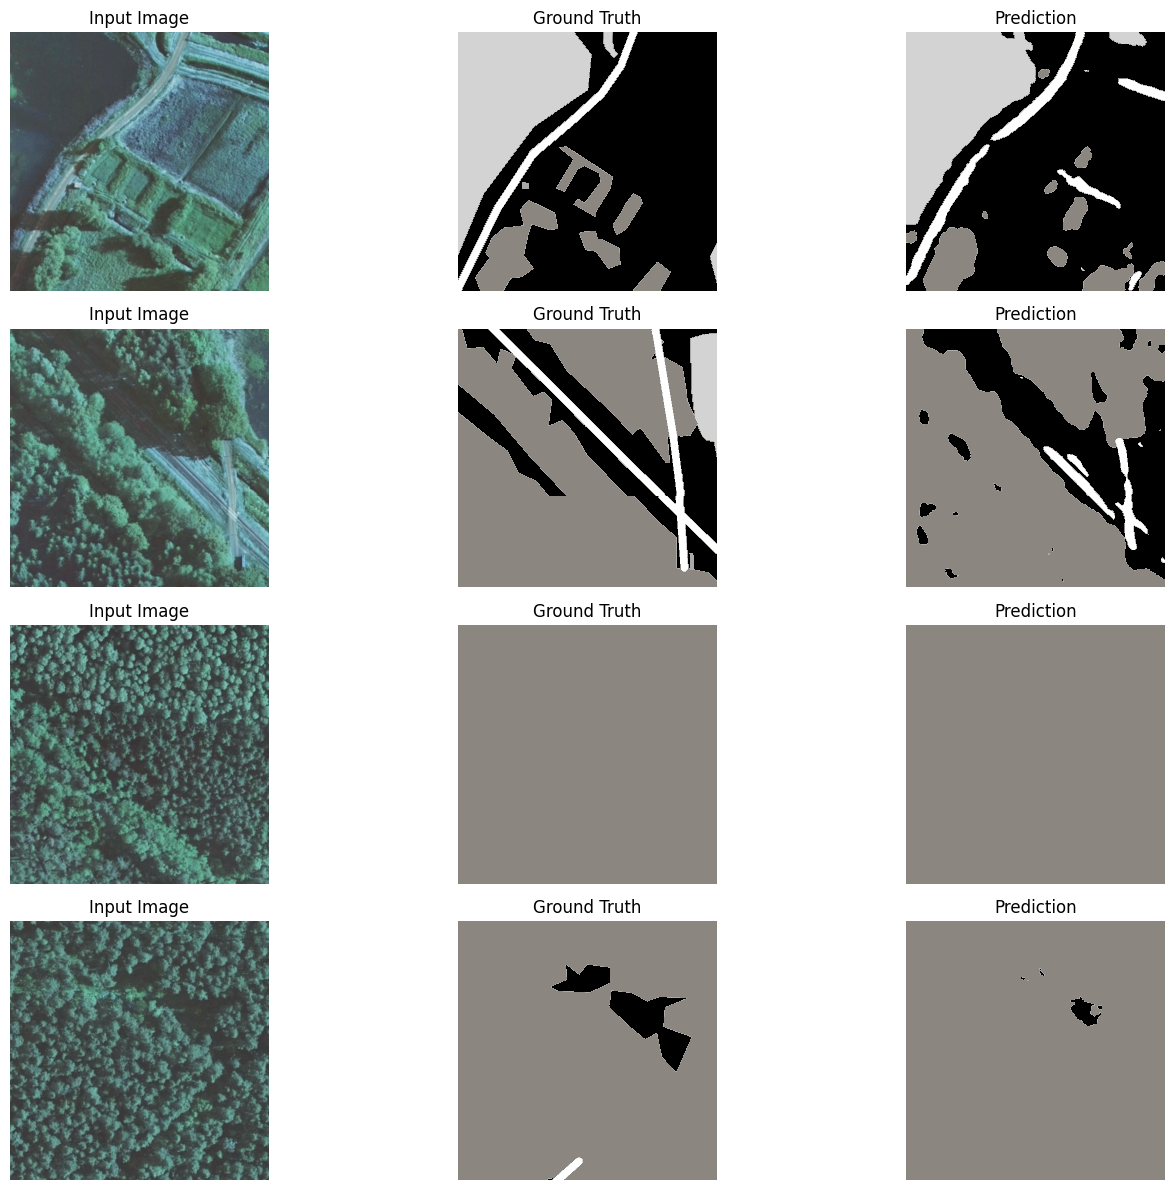


Visualizing BGS-Net predictions...


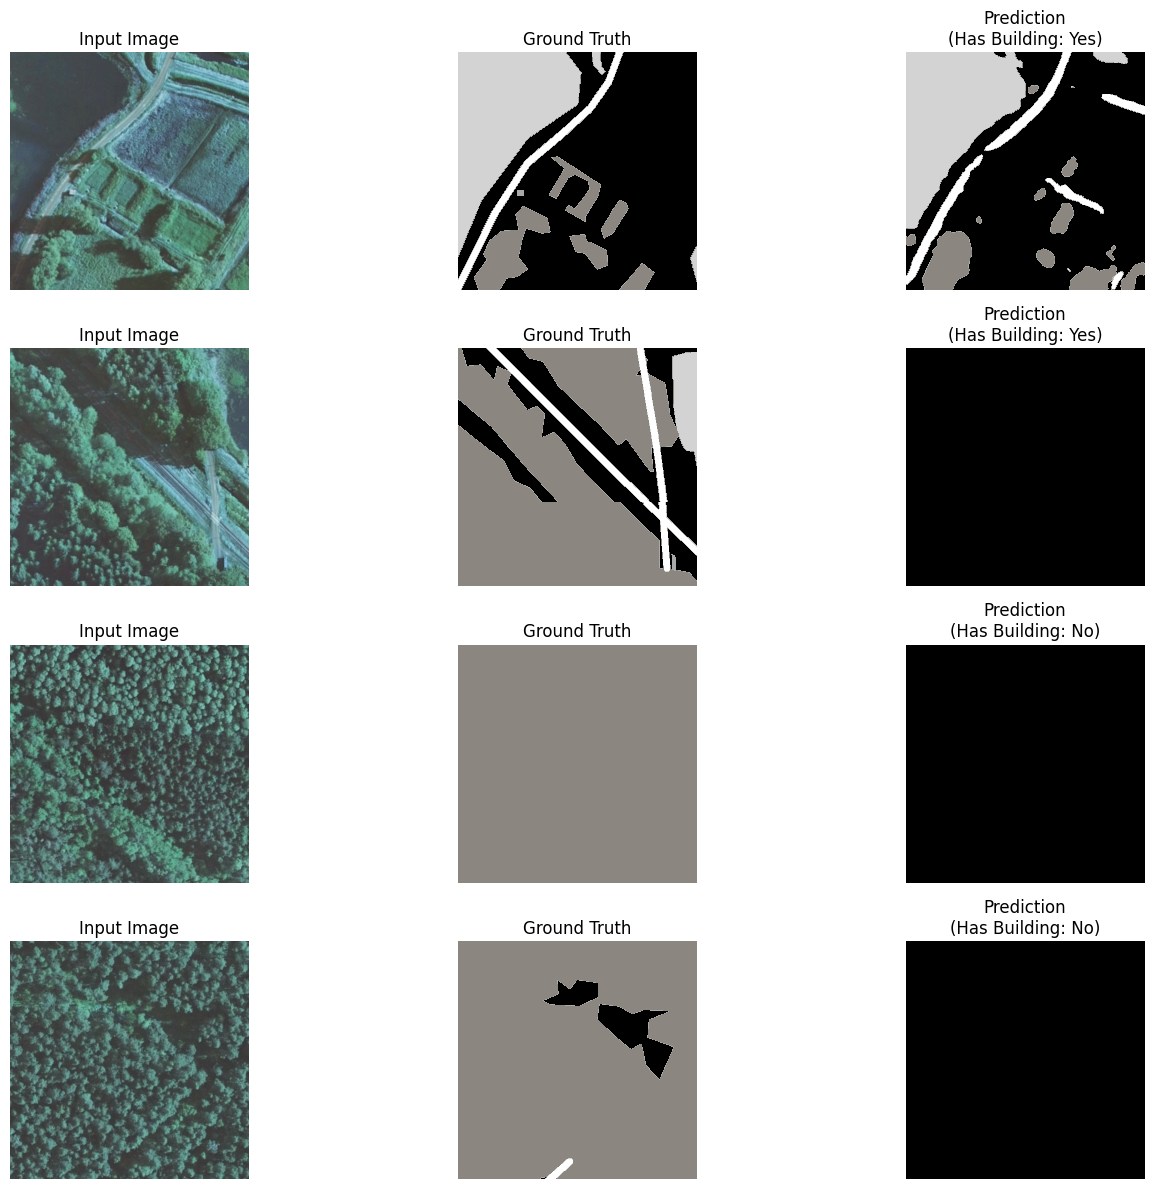


Visualizing building detection examples...
Searching for detection examples...


 17%|█▋        | 270/1602 [00:06<00:31, 42.00it/s]


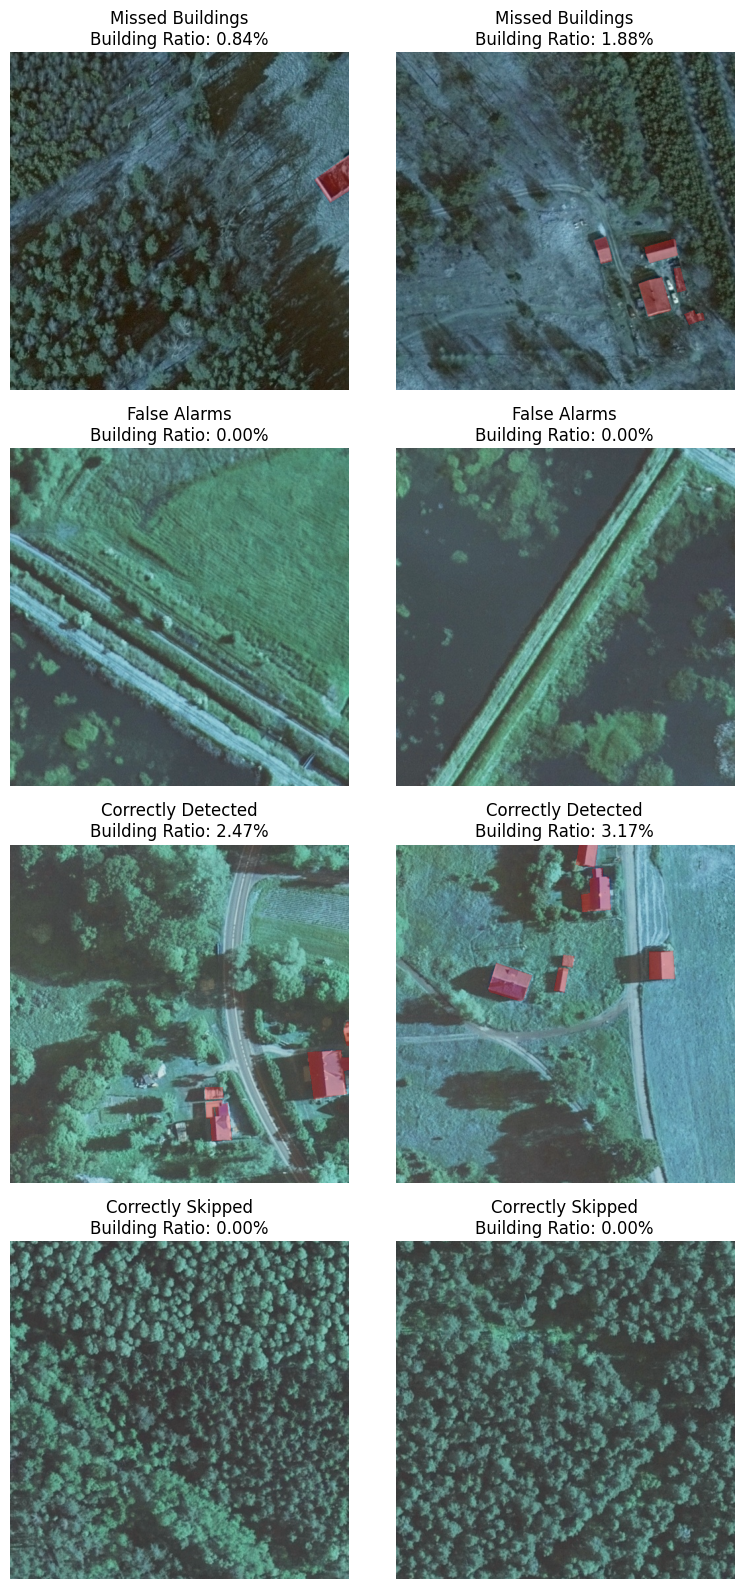


=== Step 8: Summary ===
U-Net Building IoU (Global): 0.7202
BGS-Net Building IoU (Global): 0.7014
IoU Difference: 0.0188
Computation Reduction: 49.38%
Execution Rate: 50.62%
Building Detection Recall: 89.13%
Inference Speedup: 1.37x

Consistency Check:
Building patches from evaluation: 230
Building patches from detection analysis: 230


In [26]:
results = run_inference_pipeline()